In [4]:
# Standard library imports
import random

# Third-party imports
import torch
from torch import Tensor, nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from tqdm.notebook import tqdm

# Local application imports
from agent import AgentBase
import utils

In [2]:
n_games, max_t = 500, 1000
chkpt_dir = 'checkpoint/'

env_id = 'LunarLander-v2'
state_shape = (8, )
action_shape = (1, )
action_space = [0, 1, 2, 3]

# 1. Off-Policy Agent

In [3]:
class DeepQNetwork(nn.Module):
    def __init__(self, n_inp: int, features: list[int], n_actions: int):
        super().__init__()

        # Create a list of layer sizes including input, hidden, and output layers
        layer_sizes = [n_inp] + features + [n_actions]

        # Initialize an empty sequential container
        self.net = nn.Sequential()

        # Loop through the layer sizes to create the network
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer
            self.net.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            
            # Add ReLU activation function for all layers except the last one
            if i != len(layer_sizes) - 2:
                self.net.append(nn.ReLU(inplace=True))

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        # Pass the input state through the network
        return self.net(state)

In [4]:
'''
checkout https://www.youtube.com/watch?v=wc-FxNENg9U&t
this is the implementation of that tutorial
while the tutorial dont implement Q-target Network
this is the tutorial that implement Q-target Network:
https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html

The target network is a separate neural network that is used to estimate the target values
for the Q-learning update rule. It is a copy of the main network, but its parameters are 
updated less frequently, which helps stabilize the learning process.

Using a single neural network for both estimating the current Q-values and updating the 
target Q-values can lead to instability in the learning process. This is because the 
network’s parameters are constantly changing, causing the target values to shift as well. To 
address this issue, the concept of a target network is introduced.

The target network is a separate neural network that is periodically updated with the 
parameters of the main Q-network. This means that the target values used for the Q-learning 
update rule remain more stable, allowing for a more stable learning process. For example, 
consider a reinforcement learning problem where an agent is learning to navigate a maze.
The agent uses a Q-network to estimate the Q-values for each possible action in its current 
state. To update the Q-values, the agent also needs to estimate the target Q-values for the 
next state. Instead of using the same Q-network for this purpose, the agent uses a separate 
target network, which is updated less frequently. This helps stabilize the learning process 
and allows the agent to learn more effectively.

In summary, a target network is a separate neural network used in deep reinforcement learning 
algorithms to stabilize the learning process. It is a copy of the main Q-network, but its 
parameters are updated less frequently, providing more stable target values for the Q-learning 
update rule.
'''

class DQN(AgentBase):
    def __init__(
            self,
            gamma: float,
            lr: float,
            state_shape: int,
            action_shape: int,
            action_space: int,
            batch_size: int,
            update_every: int,
            eps_start: float = 1.0,
            eps_decay: float = 0.995,
            eps_end: float = 0.01,
            buffer_size: int = 100000,
            device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
            seed: int = 0,
    ) -> None:
        """
        Initialize a DQN agent.

        Params
        ======
            gamma (float): Discount factor for future rewards
            lr (float): Learning rate for the optimizer
            state_shape (int): Dimension of each state
            action_shape (int): Dimension of each action
            batch_size (int): Size of each training batch
            update_every (int): How often to update the network
            eps_start (float): Starting value of epsilon, for epsilon-greedy action selection
            eps_decay (float): Multiplicative factor (per episode) for decreasing epsilon
            eps_end (float): Minimum value of epsilon
            buffer_size (int): Maximum size of the replay buffer
            device (str): Device to use for tensor computations ('cpu' or 'cuda')
            seed (int): Random seed
        """
        super().__init__(state_shape, action_shape, batch_size, False, update_every, buffer_size, device, seed)

        self.gamma = gamma
        self.action_space = action_space
        self.update_every = update_every
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_end = eps_end
        self.device = device
        self.seed = seed

        # Soft update parameter
        self.tau = 1e-3

        # Local model for action value estimation
        self.local_model = DeepQNetwork(n_inp=state_shape[0], features=[256, 256], n_actions=len(action_space)).to(device)
        # Target model for action value estimation
        self.target_model = DeepQNetwork(n_inp=state_shape[0], features=[256, 256], n_actions=len(action_space)).to(device)
        # Optimizer for the local model
        self.optimizer = optim.Adam(self.local_model.parameters(), lr)

        # Initialize time step for updating every 'update_every' steps
        self.time_step = 0
        # Initialize epsilon for epsilon-greedy policy
        self.eps = eps_start

    def reset(self):
        """
        Resets the epsilon value by decaying it according to the epsilon decay rate.
        
        The epsilon value is updated to be the maximum of the end epsilon value and 
        the product of the current epsilon value and the epsilon decay rate.
        
        """
        self.eps = max(self.eps_end, self.eps_decay * self.eps)

    @torch.no_grad()
    def act(self, state: np.ndarray) -> int:
        """
        Select an action for the given state using an epsilon-greedy policy.

        Params
        ======
            state (np.ndarray): Current state

        Returns
        =======
            action (int): Action to be taken
        """
        # Determine epsilon value based on evaluation mode
        if self.eval:
            eps = 0
        else:
            eps = self.eps

        # Epsilon-greedy action selection
        if random.random() >= eps:
            # Convert state to tensor and move to the appropriate device
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)

            # Set local model to evaluation mode
            self.local_model.eval()
            # Get action values from the local model
            action_value = self.local_model(state)
            # Set local model back to training mode
            self.local_model.train()

            # Return the action with the highest value
            return np.argmax(action_value.cpu().data.numpy())
        else:
            # Return a random action from the action space
            return random.choice(self.action_space)

    def learn(self, states: Tensor, actions: Tensor, rewards: Tensor, next_states: Tensor, terminals: Tensor):
        """
        Update the value network using a batch of experience tuples.

        Params
        ======
            states (Tensor): Batch of current states
            actions (Tensor): Batch of actions taken
            rewards (Tensor): Batch of rewards received
            next_states (Tensor): Batch of next states
            terminals (Tensor): Batch of terminal flags indicating episode end
        """
        # Get the maximum predicted Q values for the next states from the target model
        q_targets_next = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)

        # Compute the Q targets for the current states
        q_targets = rewards + (self.gamma * q_targets_next * (~terminals))

        # Get the expected Q values from the local model
        q_expected = self.local_model(states).gather(1, actions.long())

        # Compute the loss
        loss = F.mse_loss(q_expected, q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update the target network
        self.soft_update()

    def soft_update(self):
        for target_param, local_param in zip(self.target_model.parameters(), self.local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

## 1.1. Basic training

In [5]:
env = utils.make(env_id)

In [6]:
agent = DQN(
    gamma=0.99,
    batch_size=64,
    state_shape=state_shape,
    action_shape=action_shape,
    action_space=action_space,
    buffer_size=int(1e5),
    update_every=1,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr=5e-4,
)

In [7]:
from torchsummary import summary
summary(agent.local_model, state_shape, 64, agent.device)

----------------------------------------------------------------
        Layer (type)                Input Shape               Output Shape         Param #
            Linear-1                    [64, 8]                  [64, 256]           2,304
              ReLU-2                  [64, 256]                  [64, 256]               0
            Linear-3                  [64, 256]                  [64, 256]          65,792
              ReLU-4                  [64, 256]                  [64, 256]               0
            Linear-5                  [64, 256]                    [64, 4]           1,028
Total params: 69,124
Trainable params: 69,124
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.50
Params size (MB): 0.26
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


In [8]:
scores = agent.fit(env, n_games, max_t, save_best=True, save_last=False, save_dir = chkpt_dir, progress_bar=tqdm)

  0%|          | 0/500 [00:00<?, ?it/s]

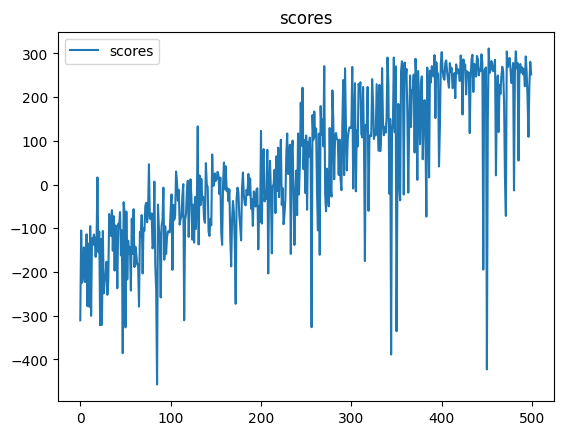

In [9]:
utils.plotting(np.arange(n_games), scores = scores)

In [10]:
env = utils.make(env_id, render_mode = 'human')


agent.load(chkpt_dir)

agent.play(env)

204.56793183819232

## 1.2. Apply transform to train

In [11]:
# Create a new environment instance
env = utils.make(env_id)

# Define a custom reward transformation class
class RewardTransform(utils.Transform):
    def __init__(self, time_penalty = -0.00001) -> None:
        super().__init__()
        self.time_penalty = time_penalty
        self.t = 0
    
    def __call__(self, reward):
        # Increment time step and apply time penalty to the reward
        self.t += 1
        return reward + self.time_penalty * self.t
    
    def reset(self):
        # Reset the time step counter
        self.t = 0

# Instantiate the reward transformation
reward_tfm = RewardTransform()

# Apply the reward transformation to the environment
env.set_reward_transform(reward_tfm)

In [12]:
agent = DQN(
    gamma=0.99,
    batch_size=64,
    state_shape=state_shape,
    action_shape=action_shape,
    action_space=action_space,
    buffer_size=int(1e5),
    update_every=1,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr=5e-4,
)

In [13]:
scores = agent.fit(env, n_games, max_t, save_best=True, save_last=False, save_dir=chkpt_dir, progress_bar=tqdm)

  0%|          | 0/500 [00:00<?, ?it/s]

although this reward look bad than these above

due to the reward transform, but it's actually make the agent play faster

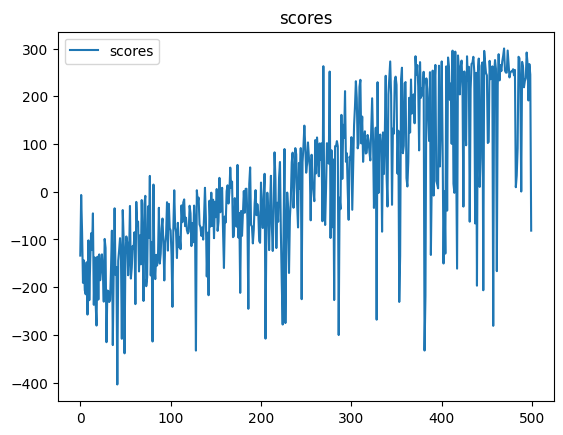

In [14]:
utils.plotting(np.arange(n_games), scores = scores)

In [15]:
env = utils.make(env_id, render_mode = 'human')

# env.set_reward_transform(reward_tfm)

agent.load(chkpt_dir)

agent.play(env)

263.63422994755604

# 2. On-Policy Agent

In [27]:
n_games = 1000

In [28]:
class Actor(nn.Module):
    def __init__(self, n_inp, n_actions, features = [128, 128]):
        super(Actor, self).__init__()

        layer_sizes = [n_inp] + features

        self.encoded = nn.Sequential()

        for i in range(len(layer_sizes) - 1):
            self.encoded.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            self.encoded.append(nn.ReLU(inplace=True))
        
        self.actor = nn.Linear(layer_sizes[-1], n_actions)

    def forward(self, x):
        return F.log_softmax(self.actor(self.encoded(x)), dim=-1)

In [29]:
class Critic(nn.Module):
    def __init__(self, n_inp, features = [128, 128]):
        super(Critic, self).__init__()
        layer_sizes = [n_inp] + features

        self.encoded = nn.Sequential()

        for i in range(len(layer_sizes) - 1):
            self.encoded.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            self.encoded.append(nn.ReLU(inplace=True))
        
        self.critic = nn.Linear(layer_sizes[-1], 1)

    def forward(self, x):
        return self.critic(self.encoded(x))

In [30]:
class A2C(AgentBase):
    def __init__(
            self, 
            state_shape, 
            action_shape,
            action_space,
            batch_size = False, 
            gamma = 0.99,
            actor_lr = 5e-4,
            critic_lr = 5e-4,
            update_every = 1, 
            buffer_size = int(1e5), 
            device = 'cpu', 
            seed = 0, 
            **kwargs
        ):
        super().__init__(state_shape, action_shape, batch_size, True, update_every, buffer_size, device, seed, **kwargs)

        self.gamma = gamma

        n_action = len(action_space)


        self.actor = Actor(state_shape[0], n_action).to(self.device)
        self.critic = Critic(state_shape[0]).to(self.device)

        self.actor.apply(utils.init_weights)
        self.critic.apply(utils.init_weights)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

    def act(self, state: np.ndarray) -> np.ndarray:
        state = torch.from_numpy(state).unsqueeze(0).float().to(self.device)
        log_probs = self.actor(state)
        action = torch.distributions.Categorical(log_probs.exp()).sample()

        return action.detach().cpu().numpy()[0]
    
    def calc_returns(self, rewards):
        returns = np.zeros_like(rewards)
        R = 0

        for i in reversed(range(len(rewards))):
            R = rewards[i] + R * self.gamma
            returns[i] = R
            
        returns = torch.from_numpy(returns)
        
        returns = (returns - returns.mean()) / returns.std()
            
        return returns

    def calc_advantages(self, returns, values):
        advantages = returns - values
        return (advantages - advantages.mean()) / advantages.std()

    
    def learn(self, states: Tensor, actions: Tensor, rewards: Tensor, next_states: Tensor, terminals: Tensor):
        values = self.critic(states).squeeze(1)

        log_probs = self.actor(states).gather(1, actions.long()).squeeze(1)

        returns = self.calc_returns(rewards).detach().squeeze(1)

        advantages = self.calc_advantages(returns, values).detach()

        policy_loss = -(log_probs * advantages).sum()
        value_loss = F.smooth_l1_loss(returns, values).sum()

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        policy_loss.backward()
        value_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()


In [31]:
env = utils.make(env_id)

agent = A2C(
    state_shape=state_shape, 
    action_shape=action_shape, 
    action_space=action_space
)

In [32]:
scores = agent.fit(env, n_games, max_t, save_best = True, save_dir=chkpt_dir, progress_bar=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

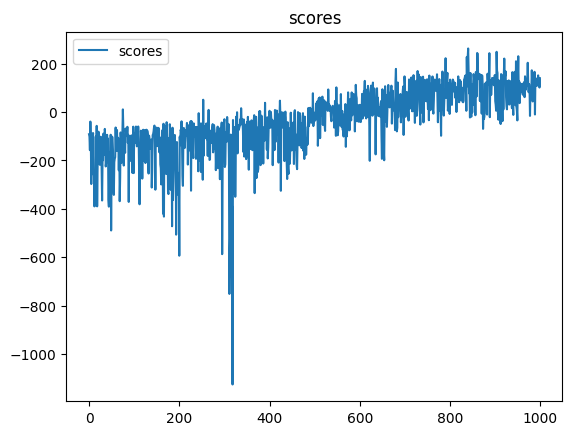

In [33]:
utils.plotting(np.arange(n_games), scores=scores)

In [34]:
env = utils.make(env_id, render_mode='human')

agent.load(chkpt_dir)

agent.play(env)

112.37786410337544